# Stock Market Prediction: Modeling

In this series of notebooks, I will create a machine learning algorithm to predict the stock price (Adjusted Close) and make a trading recommendation for the user. 

The input features are:
- Open 
- Close
- Low
- High

For the following stocks, I will create a trained algorithm:
- *Blue chip stocks*: Blue chip stocks are shares of large, established companies with stable financial performance and low risk.
    - BMW (BMW.DE)
    <p>&nbsp;</p> 
- *Growth stocks*: growth stocks are stocks of companies with high potential for future growth. These stocks often carry higher risks, but also offer higher potential returns
    - Tesla, Inc. (TSLA)
    - Bitcoin (BTC-USD)
    <p>&nbsp;</p>
- *Dividend stocks*: dividend stocks are stocks of companies that pay regular dividends to their shareholders. These stocks often carry lower risks and offer a regular source of income. 
    - Johnson & Johnson (JNJ)
    <p>&nbsp;</p>
- *Small-cap stocks*: small-cap stocks are stocks of small companies with higher risk and higher potential for growth and return.
     - Etsy, Inc (ETSY)

The following algorithms will be tested on their performance:
- Random Forest
- LSTM

This are popular algorithms for stock prediction. 

The goal is to create an algorithm which can predict the stock prices with a tolerance of ± 5%.
Also, I want to show how the different stock categories influence the accuracy of the algorithm. 

The final program on Github.com (https://github.com/maximkiesel1/Stock_Market_Prediction)  can be used for all stocks.

In this notebook, the focus will be to do feature engineering, splitting the data, train the models and validate the performance. 

## Table Of Contents 

#### 1. [Feature Engineering](#fe)  
#### 2. [Random Forest](#rf)
#### 3. [LSTM](#lstm)

In [ ]:
# load libraries
import sys

from sqlalchemy import create_engine, text, inspect
import ssl

import pandas as pd
import numpy as np

import ta

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.models import load_model
import pickle

import logging
import absl.logging

## <a class="anchor" id="fe"> 1. Feature Engineering </a>

In [2]:
def load_data(database_filepath):
    '''
    Loading the data from a sql database and transform it to X, y data for the machine learning model.
    
    INPUT 
    database_filepath - (str) path to the sql database
      
    OUTPUT
    Xs - (dict) Features dfs for the stocks
    ys - (dict) Target variables for the stocks
    '''
    # create the engine for the sql database
    engine = create_engine(f'sqlite:///{database_filepath}')
    
    # create a connection
    conn = engine.connect()
    
    # find the table names in the db
    inspector = inspect(engine)
    table_names = inspector.get_table_names()

    # create empty dict
    ys = {}
    Xs = {}
    
    for name in table_names:
        
        # transform to a executable object for pandas
        sql = text("SELECT * FROM '{}'".format(name))
        
        # create the dataframe
        df = pd.read_sql(sql, conn)

        # remove hours, minutes, and seconds from the date
        df['date'] = pd.to_datetime(df['date']).dt.date
        
        # set the date as index
        df = df.set_index('date')
        
        # delete 'Close' column, because the 'Adj Close' is relevant
        df = df.drop('Close', axis=1)
        
        # data split y
        y = df['Adj Close']
        ys[name] = y
        
        # data split X
        X = df.drop(columns=['Adj Close'])
        Xs[name] = X
        

    return Xs, ys


In [3]:
# load data
Xs, ys = load_data('/Users/maximkiesel/PycharmProjects/Stock_Market_Prediction/Data/cleaned_data.db')

I will know explain the new features:

- *Moving Averages (SMA, EMA)*: A moving average calculates the average price of a security or other asset over a specified period of time. The Simple Moving Average (SMA) is the average price over the specified time period. Exponential Moving Average (EMA) is a type of moving average that places more emphasis on the most recent data.
<p>&nbsp;</p>
- *Bollinger Bands*: Bollinger Bands are an indicator of the volatility of securities or other assets. They consist of three lines: a simple moving average line, an upper band line, and a lower band line that are two standard deviations away from the simple moving average.
<p>&nbsp;</p>
- *Average True Range (ATR)*: The Average True Range is a measure of the volatility of a security or other asset. It is the average of the largest daily price movements of a security or asset over a given time period.
<p>&nbsp;</p>
- *MACD*: Moving Average Convergence Divergence (MACD) is an indicator of the trend and momentum changes of a security or other asset. It is calculated by subtracting the 26-period EMA from the 12-period EMA.
<p>&nbsp;</p>
- *RSI*: The Relative Strength Index (RSI) is an indicator of the strength of a trend and potential trend reversal. It is calculated by computing the ratio of average gains and losses over a given period of time.
<p>&nbsp;</p>
- *Stochastic Oscillator*: The Stochastic Oscillator is a momentum indicator that helps identify overbought and oversold conditions. It compares the closing price of a security or other asset to the high-low range over a specified time period.
<p>&nbsp;</p>
- *Stochastic signal*: The Stochastic signal is a signal or trigger line calculated from the moving average of the Stochastic oscillator. It is used to generate buy and sell signals when it crosses above or below the oscillator.

In [283]:
def feat_eng(Xs, ys):
    '''
    Create new features for the X dfs and clean potential Nan values.
    Adjusted the amount of y values.
    
    INPUT 
    Xs - (dict) Feature dfs of the stocks
    ys - (dict) Target variables of the stocks
      
    OUTPUT
    Xs_nor - (dict) cleaned, extended and normalized X dfs
    ys_nor - (dict) cleaned and normalized y dfs for the target variable
    Xs_1 - (dict) cleaned and extended X dfs
    ys_1 - (dict) cleaned y dfs for the target variable
    '''
    
    # create empty dict for the new dfs with the new features
    Xs_nor, ys_nor, Xs_1, ys_1= {}, {}, {}, {}
    
    for name in Xs:
        
        # define the dfs from the dict
        df = Xs[name]
        y = ys[name]

        # Moving Averages (SMA, EMA)
        df['SMA'] = ta.trend.sma_indicator(y, window=20)
        df['EMA'] = ta.trend.ema_indicator(y, window=20)

        # Bollinger Bands
        bb = ta.volatility.BollingerBands(close=y, window=20, window_dev=2)
        df['BB_High'] = bb.bollinger_hband()
        df['BB_Low'] = bb.bollinger_lband()

        # Average True Range (ATR)
        atr = ta.volatility.AverageTrueRange(high=df['High'], low=df['Low'], close=y, window=14)
        df['ATR'] = atr.average_true_range()

        # MACD
        macd = ta.trend.MACD(y, window_slow=26, window_fast=12, window_sign=9)
        df['MACD'] = macd.macd()
        df['MACD_Signal'] = macd.macd_signal()
        df['MACD_Diff'] = macd.macd_diff()

        # RSI
        df['RSI'] = ta.momentum.RSIIndicator(y, window=14).rsi()

        # Stochastic Oscillator
        stoch = ta.momentum.StochasticOscillator(high=df['High'], low=df['Low'], close=y, window=14, smooth_window=3)
        df['Stoch_Oscillator'] = stoch.stoch()
        df['Stoch_Signal'] = stoch.stoch_signal()
        
        # delete all row with no values (because of the new features)
        # find the max rows with nan values
        max_nan_row = max(df.isna().sum())
        df = df.drop(df.index[:max_nan_row])
        y= y.drop(y.index[:max_nan_row])
        
        # normalization of the features
        df_nor = (df - df.min()) / (df.max() - df.min())
        y_nor = (y - y.min()) / (y.max() - y.min())
        
        # add the df in the dict
        Xs_nor[name] = df_nor
        ys_nor[name] = y_nor
        Xs_1[name] = df
        ys_1[name] = y
        
        
    return Xs_nor, ys_nor, Xs_1, ys_1

In [284]:
# create df dict with new features
Xs_nor, ys_nor, Xs_1, ys_1 = feat_eng(Xs, ys)

In [285]:
def train_test(Xs_nor, ys_nor):
    '''
    Split the data in test and train data for X and y 
    
    INPUT 
    Xs_nor - (dict) Cleaned and normalized feature dfs of the stocks 
    ys_nor - (dict) Normalized target variables of the stocks
      
    OUTPUT
    Xs_train - (dict) Split training data of the input features
    Xs_test - (dict) Split test data of the input features
    ys_train - (dict) Split training data of the output feature
    ys_test - (dict) Split training data of the output feature
    '''
    
    # define empty dict 
    Xs_train = {}
    Xs_test = {}
    ys_train = {}
    ys_test = {}
    
    # iterate through the dict
    for name in Xs_nor:
        # select the data for the stocks
        X = Xs_nor[name]
        y = ys_nor[name]
        
        # 80% splitting of the data in train and test
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        
        # insert in the new dict
        Xs_train[name] = X_train
        Xs_test[name] = X_test
        ys_train[name] = y_train
        ys_test[name] = y_test
    
    return Xs_train, Xs_test, ys_train, ys_test

In [286]:
# create the split data sets
Xs_train, Xs_test, ys_train, ys_test = train_test(Xs_nor, ys_nor)

## <a class="anchor" id="rf"> 2. Random Forest </a>

In this step, I will create a Regression Random Forest algorithm to predict the stock price. 

In [287]:
# Define the parameter grid
parameters = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5]
}


# Create random forest regression object
reg_forest = RandomForestRegressor()

# create empyt dict to fill with r2 scores and the predicted values
r2_train, r2_test = {}, {}
ys_train_predict, ys_test_predict = {}, {}

# create time series object for cross validation
tscv = TimeSeriesSplit(n_splits=5)

# Create the GridSearchCV object
grid_search = GridSearchCV(reg_forest, parameters, cv=tscv, scoring='r2')

for name in Xs_train:
    # Fit the GridSearchCV object to the data
    grid_search.fit(Xs_train[name], ys_train[name])

    # Get the best estimator
    best_estimator = grid_search.best_estimator_

    # Get the best hyperparameters
    best_params = grid_search.best_params_
    
    print('The best hyperparameter for the stock {} are: {}.'.format(name, best_estimator))

    # Get the R^2 scores for the train and test sets
    ys_train_predict[name] = best_estimator.predict(Xs_train[name])
    r2_train[name] = r2_score(ys_train[name], ys_train_predict[name]) 
    ys_test_predict[name] = best_estimator.predict(Xs_test[name])
    r2_test[name] = r2_score(ys_test[name], ys_test_predict[name]) 
    
    diff = sum(ys_test_predict[name]-ys_test[name])

The best hyperparameter for the stock BMW.DE are: RandomForestRegressor(max_features=0.5, min_samples_split=5, n_estimators=50).
The best hyperparameter for the stock BTC-USD are: RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=150).
The best hyperparameter for the stock ETSY are: RandomForestRegressor(max_depth=20, max_features=0.5, n_estimators=50).
The best hyperparameter for the stock JNJ are: RandomForestRegressor(max_features=0.5, n_estimators=150).
The best hyperparameter for the stock TSLA are: RandomForestRegressor(max_features=0.5, n_estimators=50).


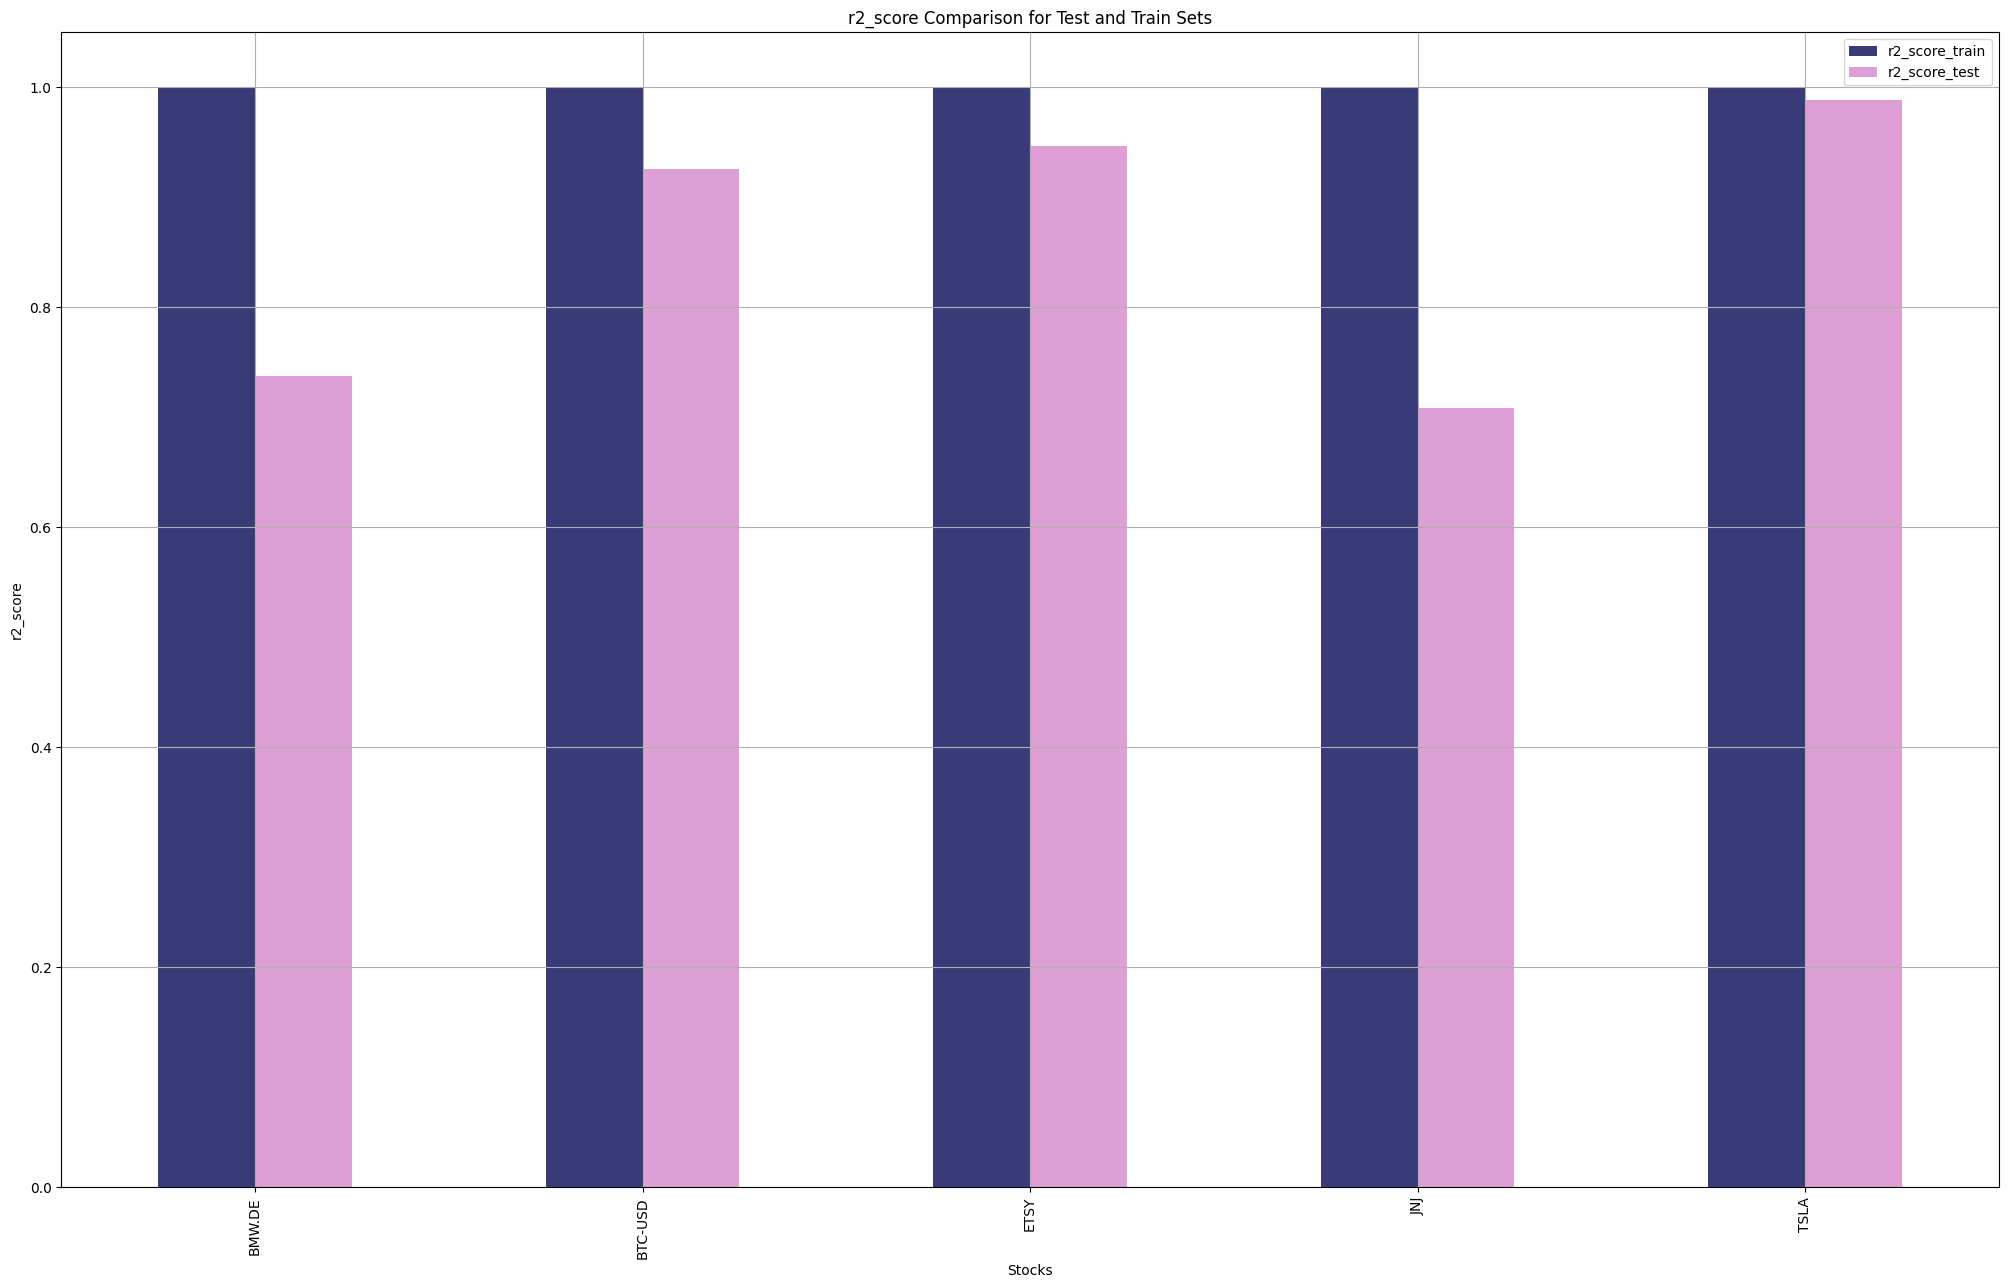

In [288]:
# create dataframes out of the dict
df_train = pd.DataFrame.from_dict(r2_train, orient='index', columns=['r2_score_train'])
df_test = pd.DataFrame.from_dict(r2_test, orient='index', columns=['r2_score_test'])

# Concatenate the dataframes
df_combined = pd.concat([df_train, df_test], axis=1)

# Plot the horizontal stacked bar chart
df_combined.plot(kind='bar', stacked=False, figsize=(25,15), colormap='tab20b')
plt.xlabel('Stocks')
plt.ylabel('r2_score')
plt.title('r2_score Comparison for Test and Train Sets')
plt.grid()
plt.show()

BMW.DE


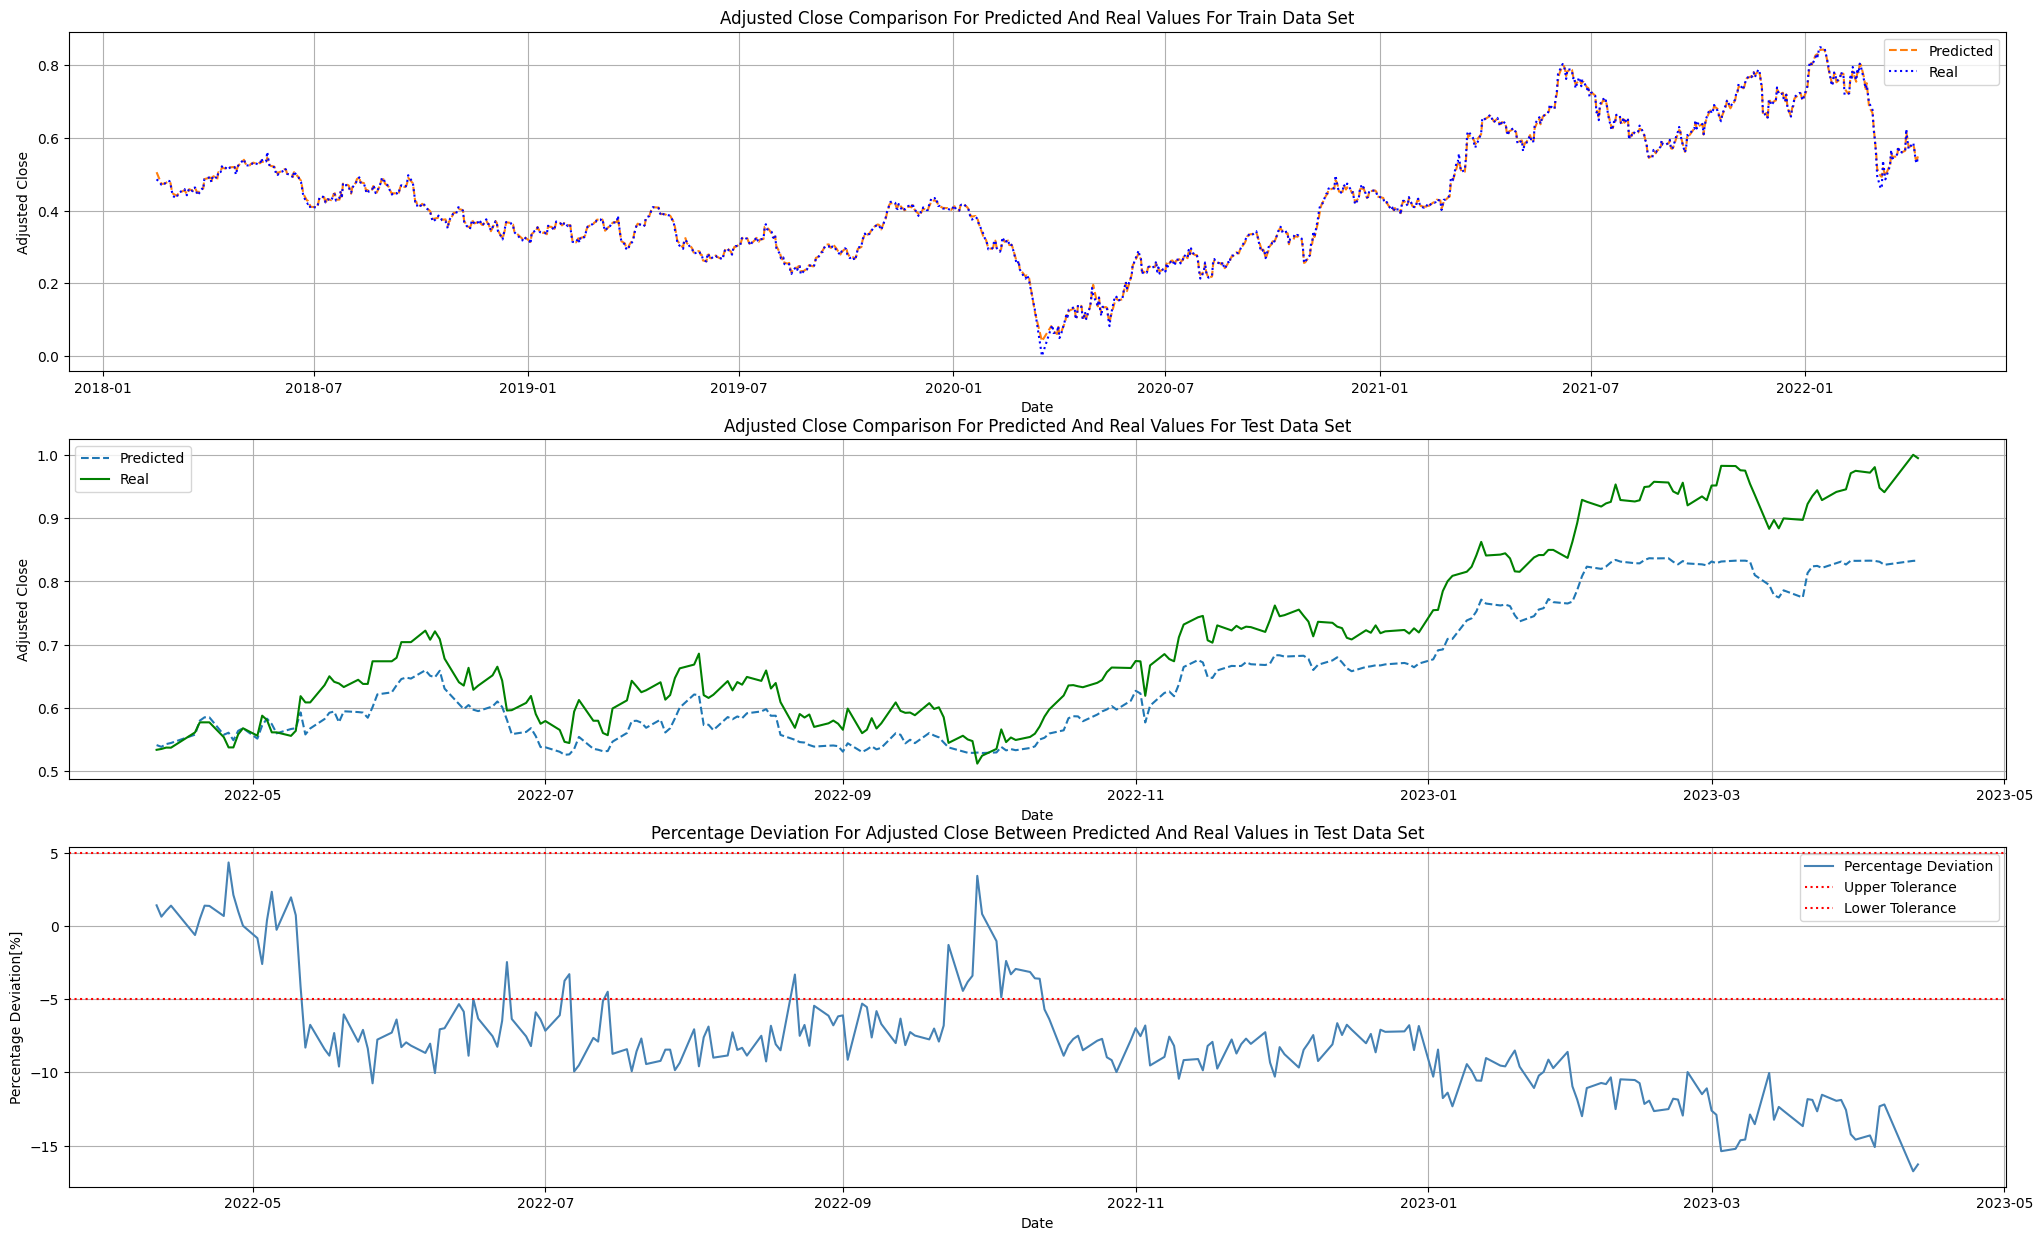

The mean for the percentage deviation in the test date is -7.839745511388107.

----------------

BTC-USD


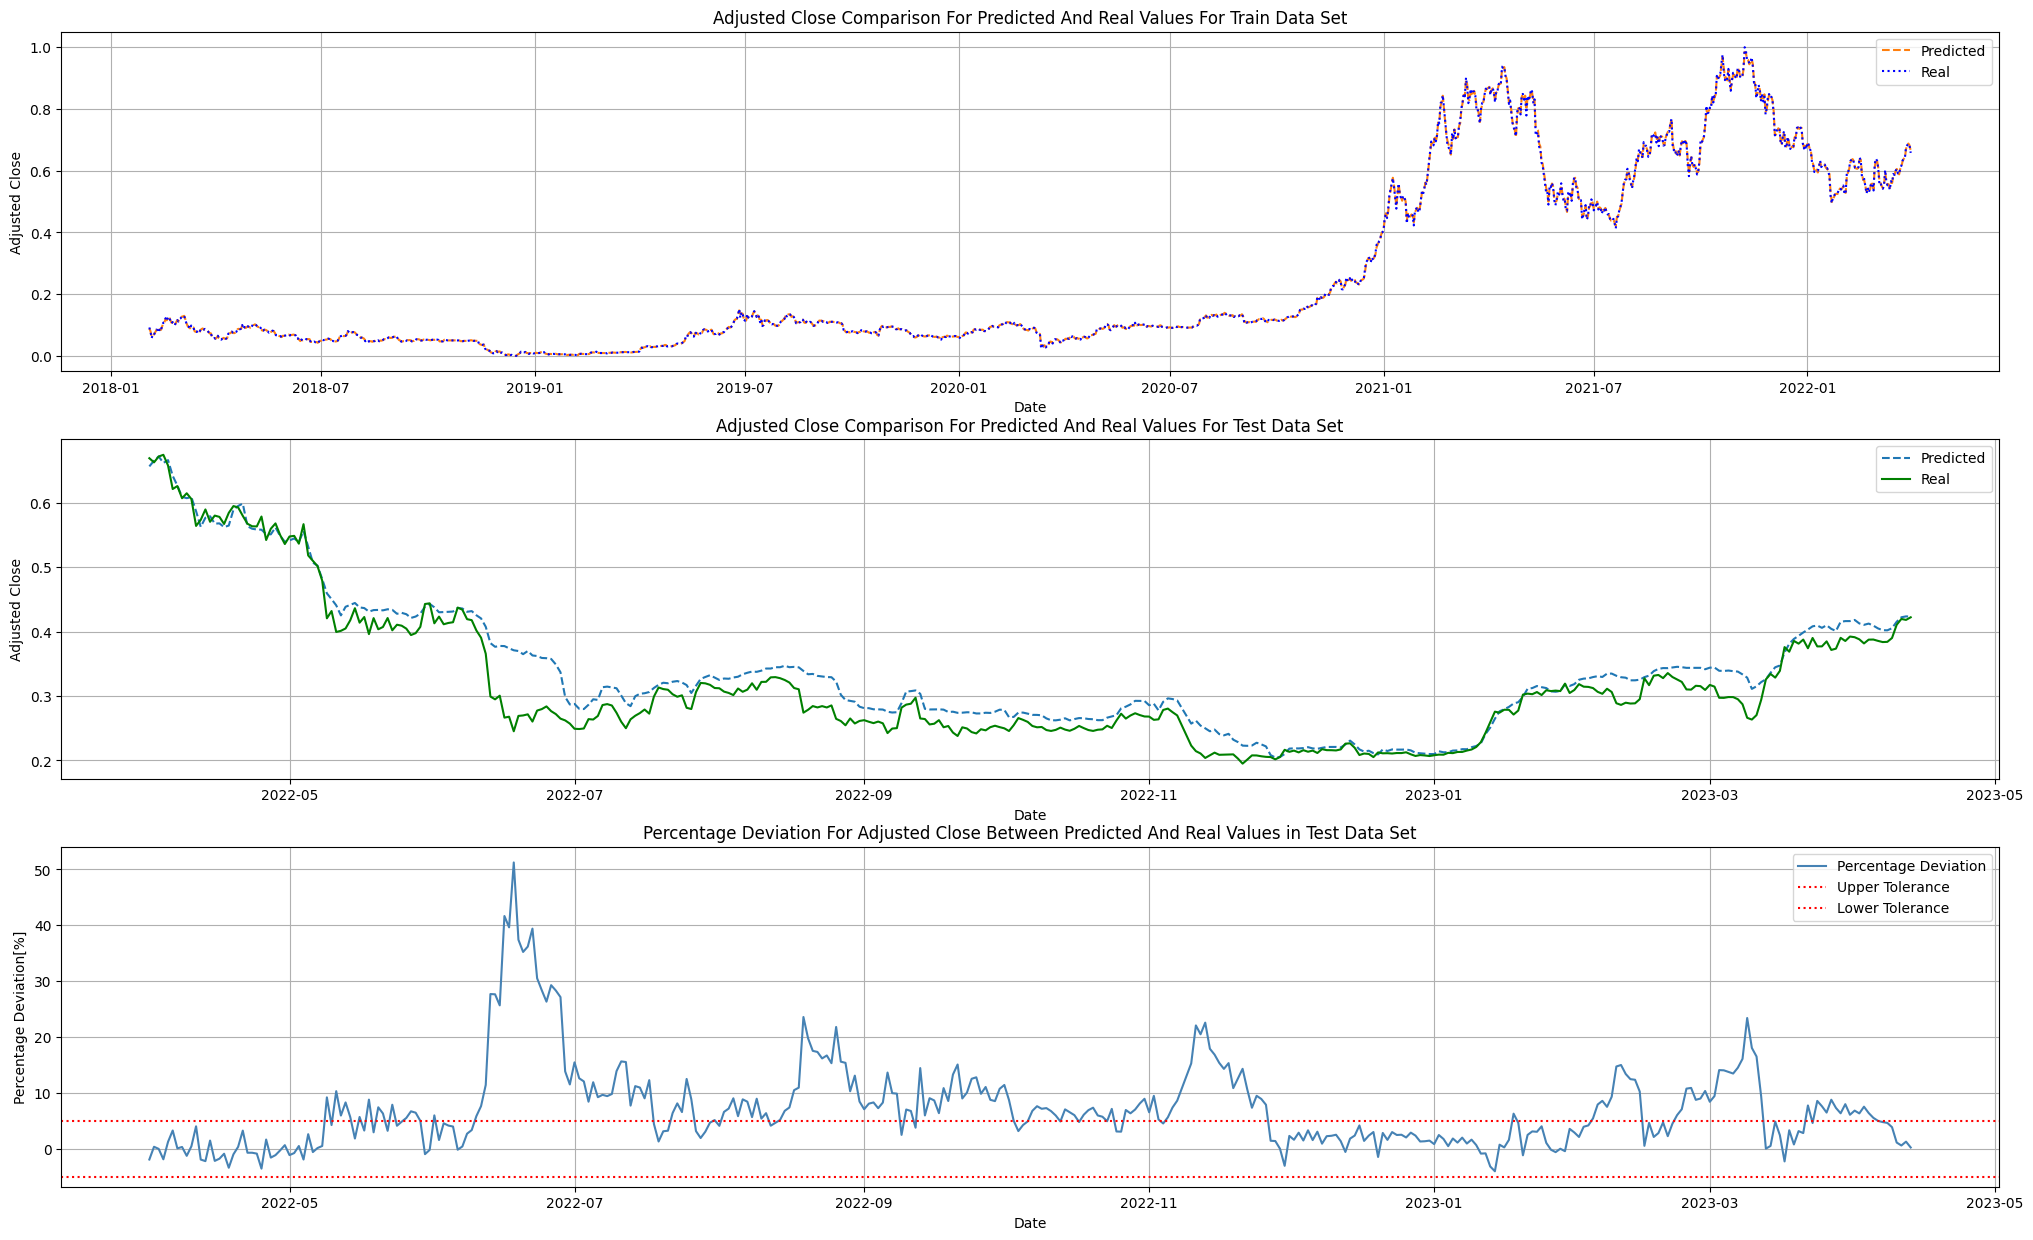

The mean for the percentage deviation in the test date is 7.231826170669565.

----------------

ETSY


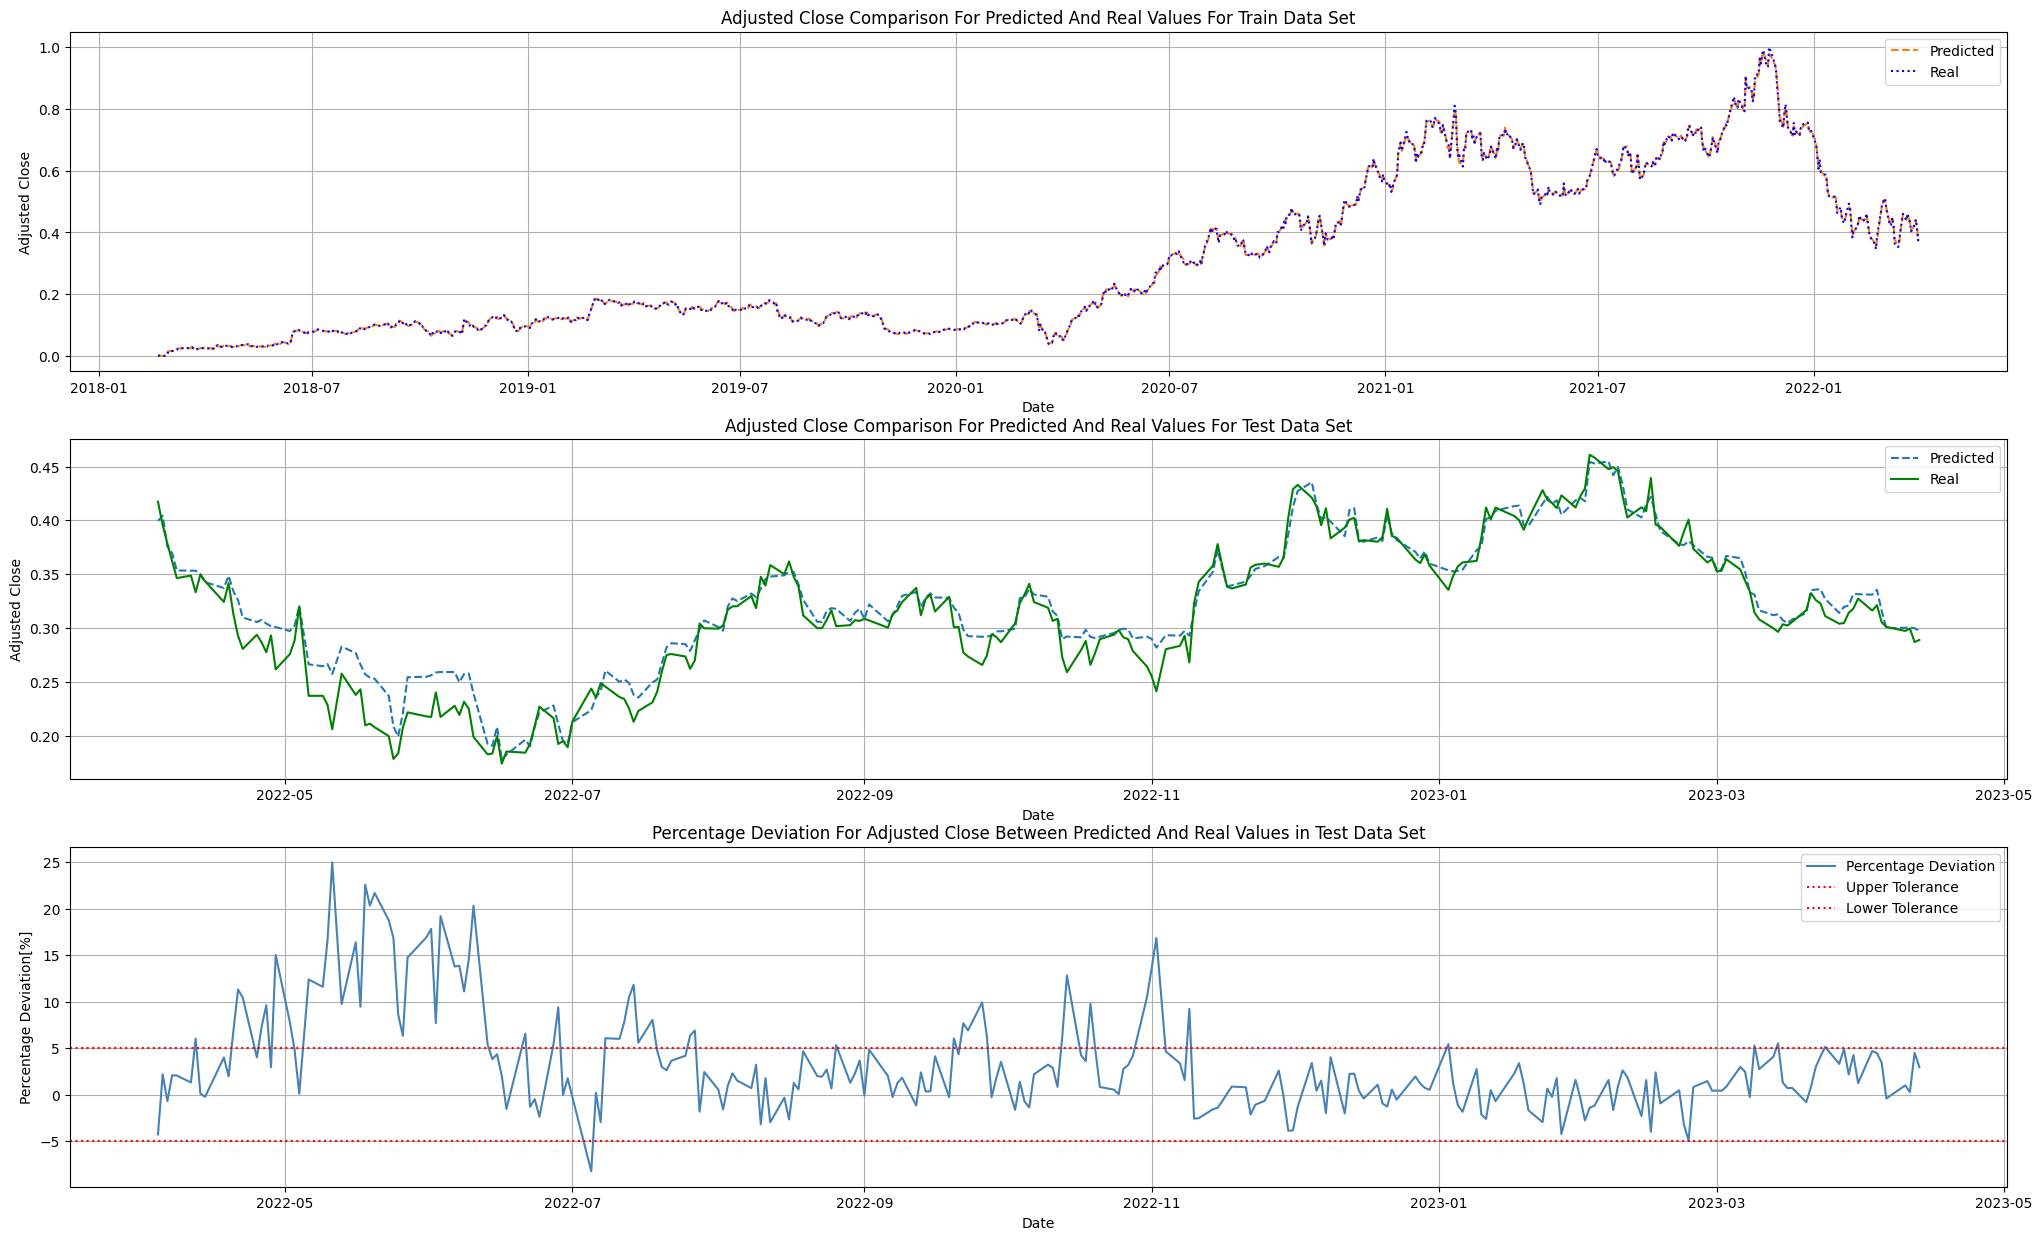

The mean for the percentage deviation in the test date is 3.3111250661943634.

----------------

JNJ


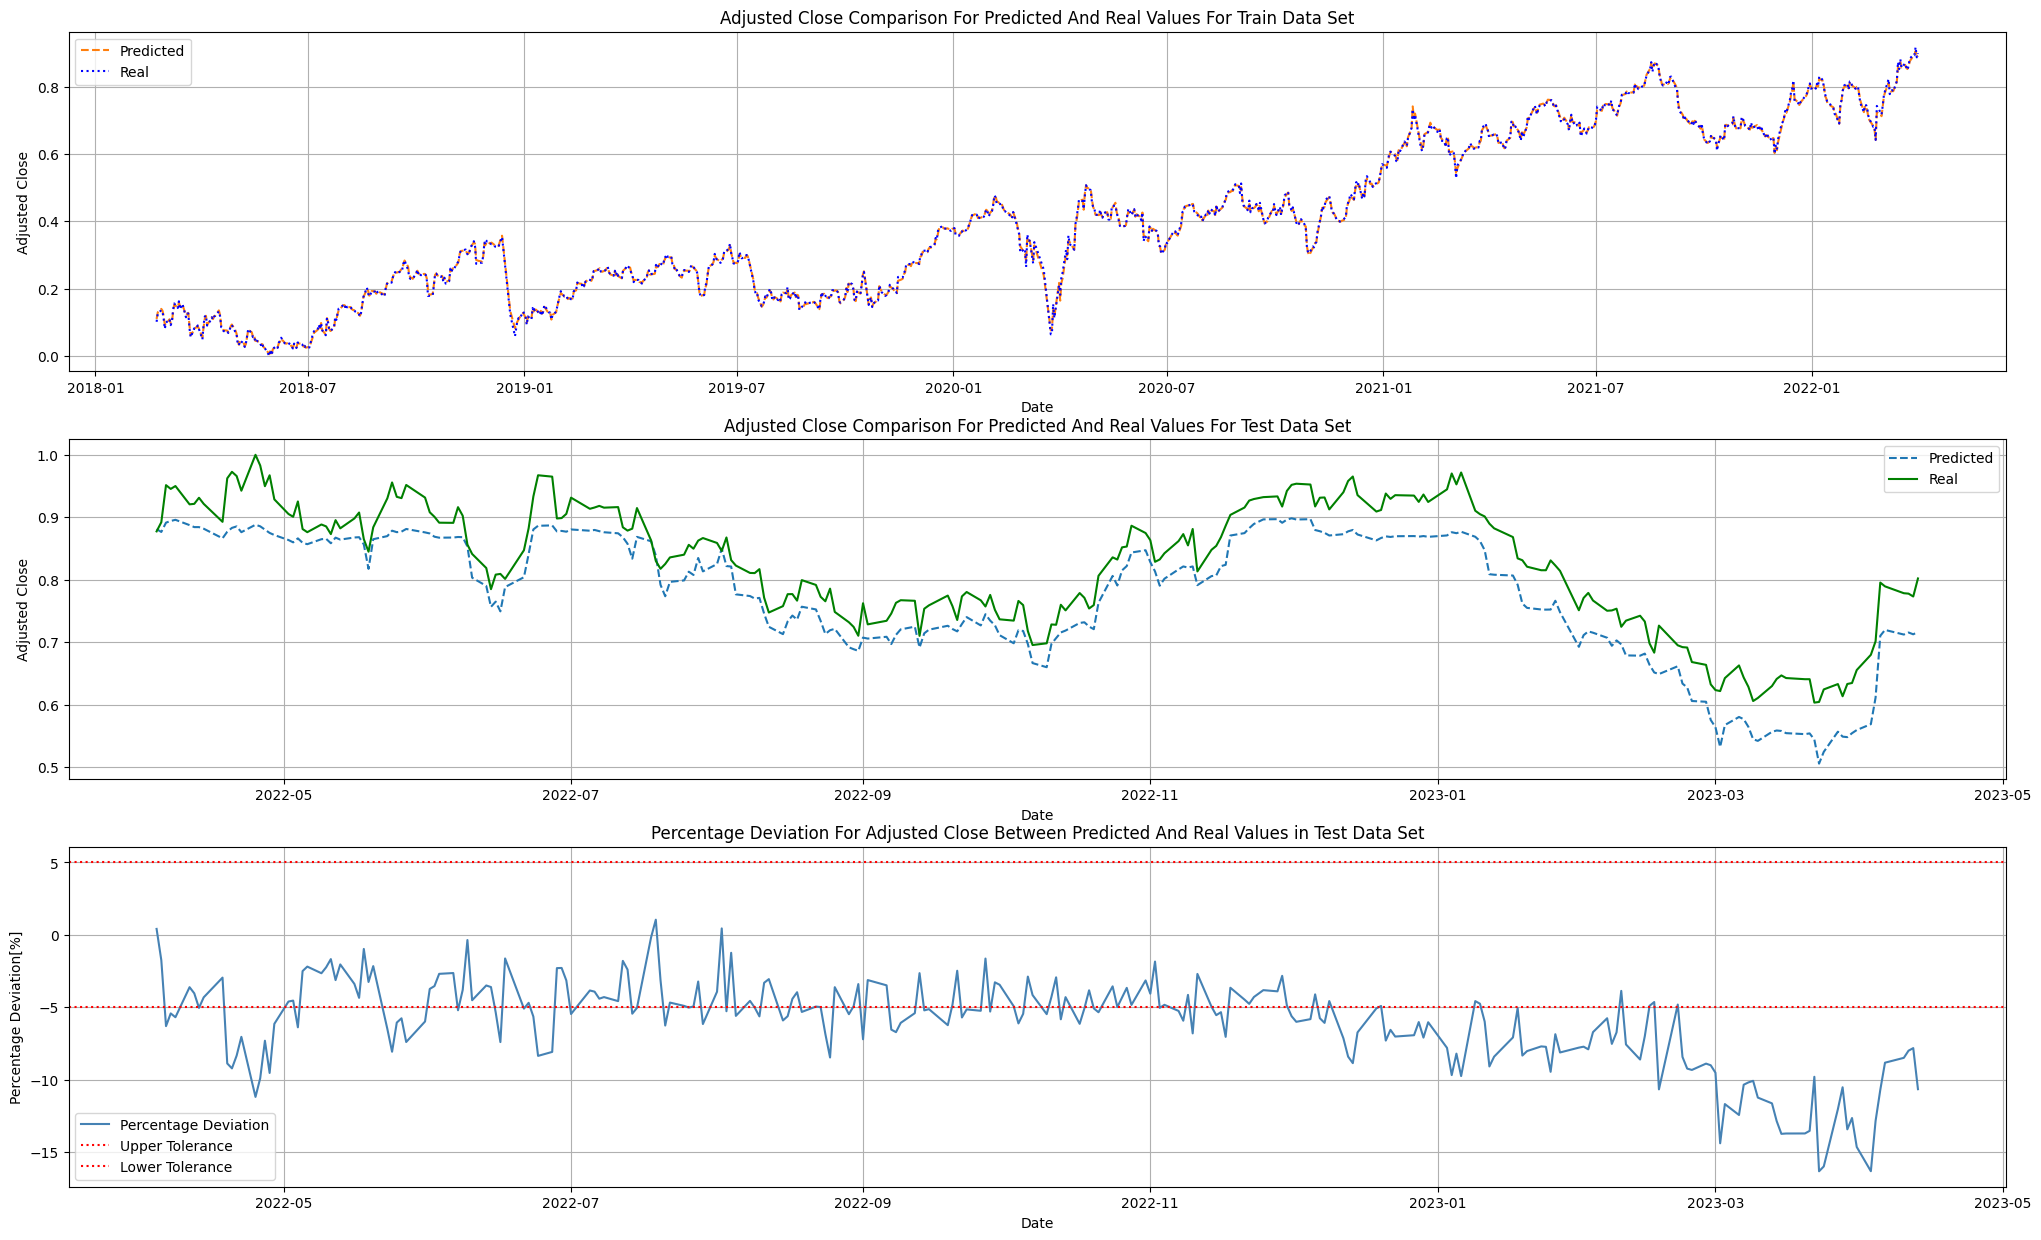

The mean for the percentage deviation in the test date is -6.019084058943902.

----------------

TSLA


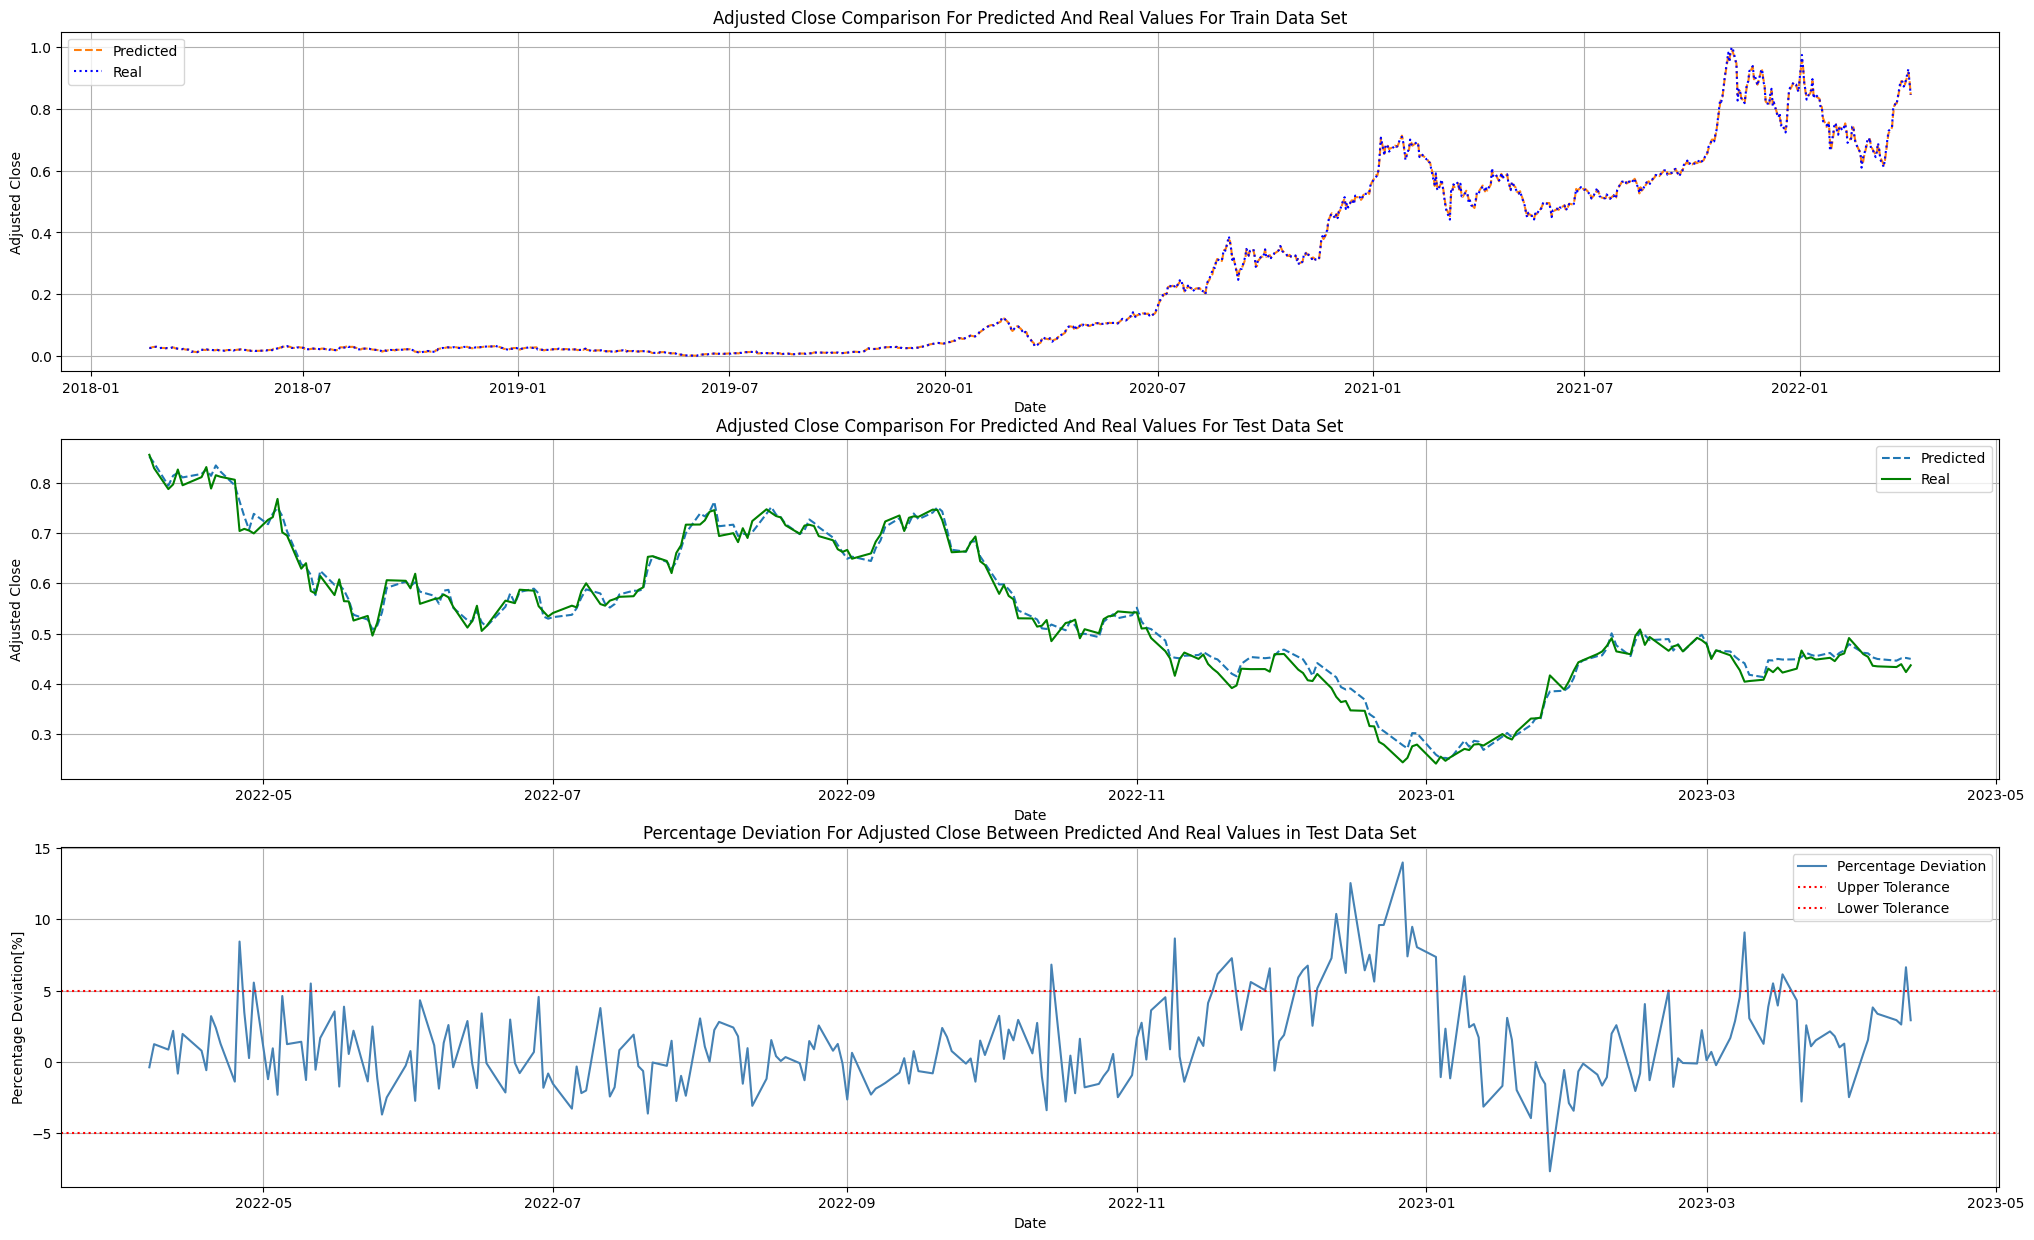

The mean for the percentage deviation in the test date is 1.3919521714423813.

----------------



In [289]:
# plot of the comparison between train and test data and the prediction

# iterate through the stocks
for name in Xs_train:
    
    print(name)
    
    # plot the comparison between predicted And real values for train data
    plt.figure()
    plt.close()
    plt.figure(figsize=(25, 15))
    plt.subplot(311)
    plt.plot(Xs_train[name].index, ys_train_predict[name], color='tab:orange', linestyle='--', label='Predicted')
    plt.plot(Xs_train[name].index, ys_train[name], color='blue', linestyle=':', label='Real')
    plt.grid()
    plt.legend()
    plt.ylabel('Adjusted Close')
    plt.xlabel('Date')
    plt.title('Adjusted Close Comparison For Predicted And Real Values For Train Data Set')
    
    # plot the comparison between predicted And real values for test data
    plt.subplot(312)
    plt.plot(Xs_test[name].index, ys_test_predict[name], color='tab:blue', linestyle='--', label='Predicted')
    plt.plot(Xs_test[name].index, ys_test[name], color='green', label='Real')
    plt.grid()
    plt.legend()
    plt.ylabel('Adjusted Close')
    plt.xlabel('Date')
    plt.title('Adjusted Close Comparison For Predicted And Real Values For Test Data Set')
    
    # plot for percentage deviation between predicted and real values in test data 
    plt.subplot(313)
    diff_test = ys_test_predict[name]-ys_test[name]
    rel_diff_test = diff_test / ys_test[name]
    percent_diff_test = rel_diff_test * 100
    plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
    plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
    plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
    plt.grid()
    plt.legend()
    plt.ylabel('Percentage Deviation[%]')
    plt.xlabel('Date')
    plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
    plt.show()
    print('The mean for the percentage deviation in the test date is {}.'.format(sum(percent_diff_test)/len(percent_diff_test)))
    print('')
    print('----------------')
    print('')

With the same conditions, just TSLA and ETSY hold the ±5% tolerance for the prediction.
That's why, the Random Forest algorithm is not enough for my specification.

**Interesting fact**: On the one hand, stocks, which are more stable in their course, tend to be worse in the prediction. For example BMW.
On the other hand, stock which are more volatile, like TSLA, were better predicted. 

## <a class="anchor" id="lstm"> 4. LSTM </a>

Now I will define a very popular algorithm for time series. It´s the Long Short-Term Memory (LSTM). A Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) architecture that is designed to model sequential data by retaining and selectively forgetting previous information. It achieves this by using a memory cell, an input gate, an output gate, and a forget gate to regulate the flow of information through the cell. 

At first, I define the algorithm for one stock ('JNJ') and compare it with the Random Forest. If it´s better and fits in the 5% tolerance, I create a more general function.

In [365]:
def train_test_lstm(Xs_nor, ys_nor, window_size):
    '''
    Splitting of the datasets in the dictionaries in train, validation, and test (60%, 20%, 20%).
    Transform the date that it can used in the lstm algorithm
    
    INPUT 
    Xs_nor - (dict) Cleaned and normalized feature dfs of the stocks 
    ys_nor - (dict) Normalized target variables of the stocks
    windows_size - 
      
    OUTPUT
    Xs_train - (dict) Splits training data of the input features
    Xs_val - (dict) Split validation data of the input features
    Xs_test - (dict) Split test data of the input features
    ys_train - (dict) Split training data of the output feature
    ys_val - (dict) Split validation data of the output feature
    ys_test - (dict) Split test data of the output feature
    '''
    
    # define empty dict 
    Xs_train = {}
    Xs_test = {}
    Xs_val = {}
    ys_train = {}
    ys_val = {}
    ys_test = {}
    
    # iterate through the dict
    for name in Xs_nor:
        
        # select the dfs
        X = Xs_nor[name]
        y = ys_nor[name]
        
        # convert to numpy
        X_np = X.to_numpy()
        y_np = y.to_numpy()
        
        # create empty lists to fill the data in the appropriated form for lstm
        X, y = [], []
        
        for i in range(len(X_np)-window_size):
            
            # select the first x data points of the input features and append them to the list
            row = [r for r in X_np[i:i+window_size]]
            X.append(row)
            
            # select the x+1 data point of the target variable and append them to the list
            label = y_np[i+window_size]
            y.append(label)
            
        # data splitting
        train_size = int(len(X) * 0.6)
        val_size = train_size + int(len(X) * 0.2)
        X_train, X_val, X_test = X[:train_size], X[train_size:val_size], X[val_size:]
        y_train, y_val, y_test = y[:train_size], y[train_size:val_size], y[val_size:]
        
        # insert split data in the dict
        Xs_train[name] = X_train
        Xs_val[name] = X_val
        Xs_test[name] = X_test
        ys_train[name] = y_train
        ys_val[name] = y_val
        ys_test[name] = y_test
        
    return Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test

In [391]:
# create the datasets
Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(Xs_nor, ys_nor, 10)

In [392]:
# define the model
model1 = Sequential()
model1.add(InputLayer((10, 15)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

model1.summary()

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_39 (LSTM)              (None, 64)                20480     
                                                                 
 dense_69 (Dense)            (None, 8)                 520       
                                                                 
 dense_70 (Dense)            (None, 1)                 9         
                                                                 
Total params: 21,009
Trainable params: 21,009
Non-trainable params: 0
_________________________________________________________________


In [393]:
# create a model checkpoint for the best model
cp1 = ModelCheckpoint('model1/', save_best_only=True)

In [394]:
# remove error messages from tensorflow
absl.logging.set_verbosity(absl.logging.ERROR)

In [395]:
# fitting the model
model1.fit(np.array(Xs_train['JNJ']), np.array(ys_train['JNJ']), validation_data=(np.array(Xs_val['JNJ']), np.array(ys_val['JNJ'])), epochs=50, callbacks=[cp1], verbose=0)

In [396]:
# load the best model
model1 = load_model('model1/')

In [397]:
# make prediction
test_predictions = model1.predict(np.array(Xs_test['JNJ'])).flatten()

# create a dataframe with predicted values and real values
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':np.array(ys_test['JNJ'])})

8/8 [==============================] - 0s 1ms/step


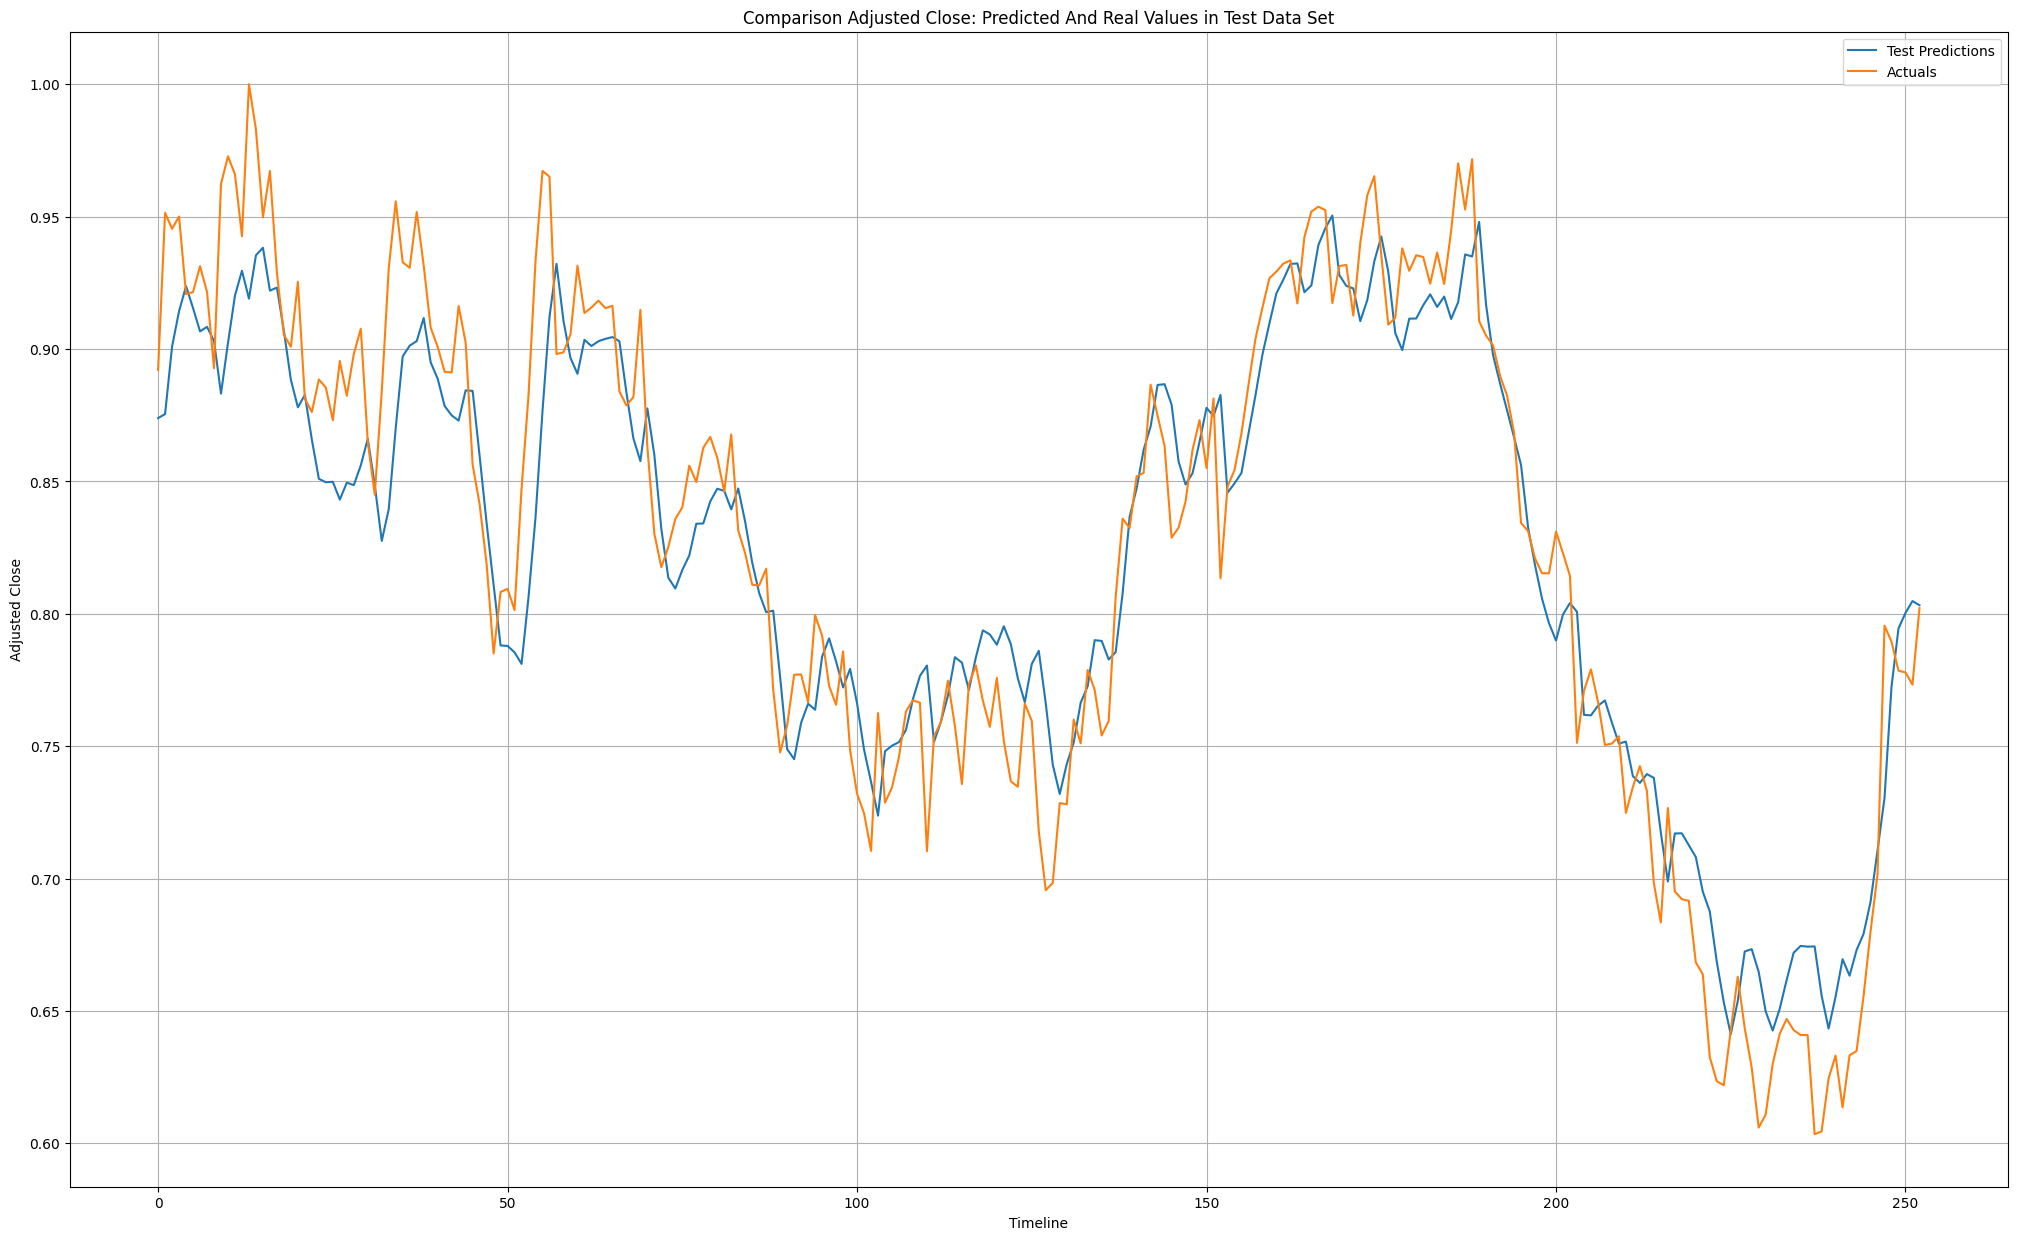

In [398]:
# plot test and ground truth data
plt.figure(figsize=(25, 15))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
plt.ylabel('Adjusted Close')
plt.xlabel('Timeline')
plt.legend()
plt.grid()

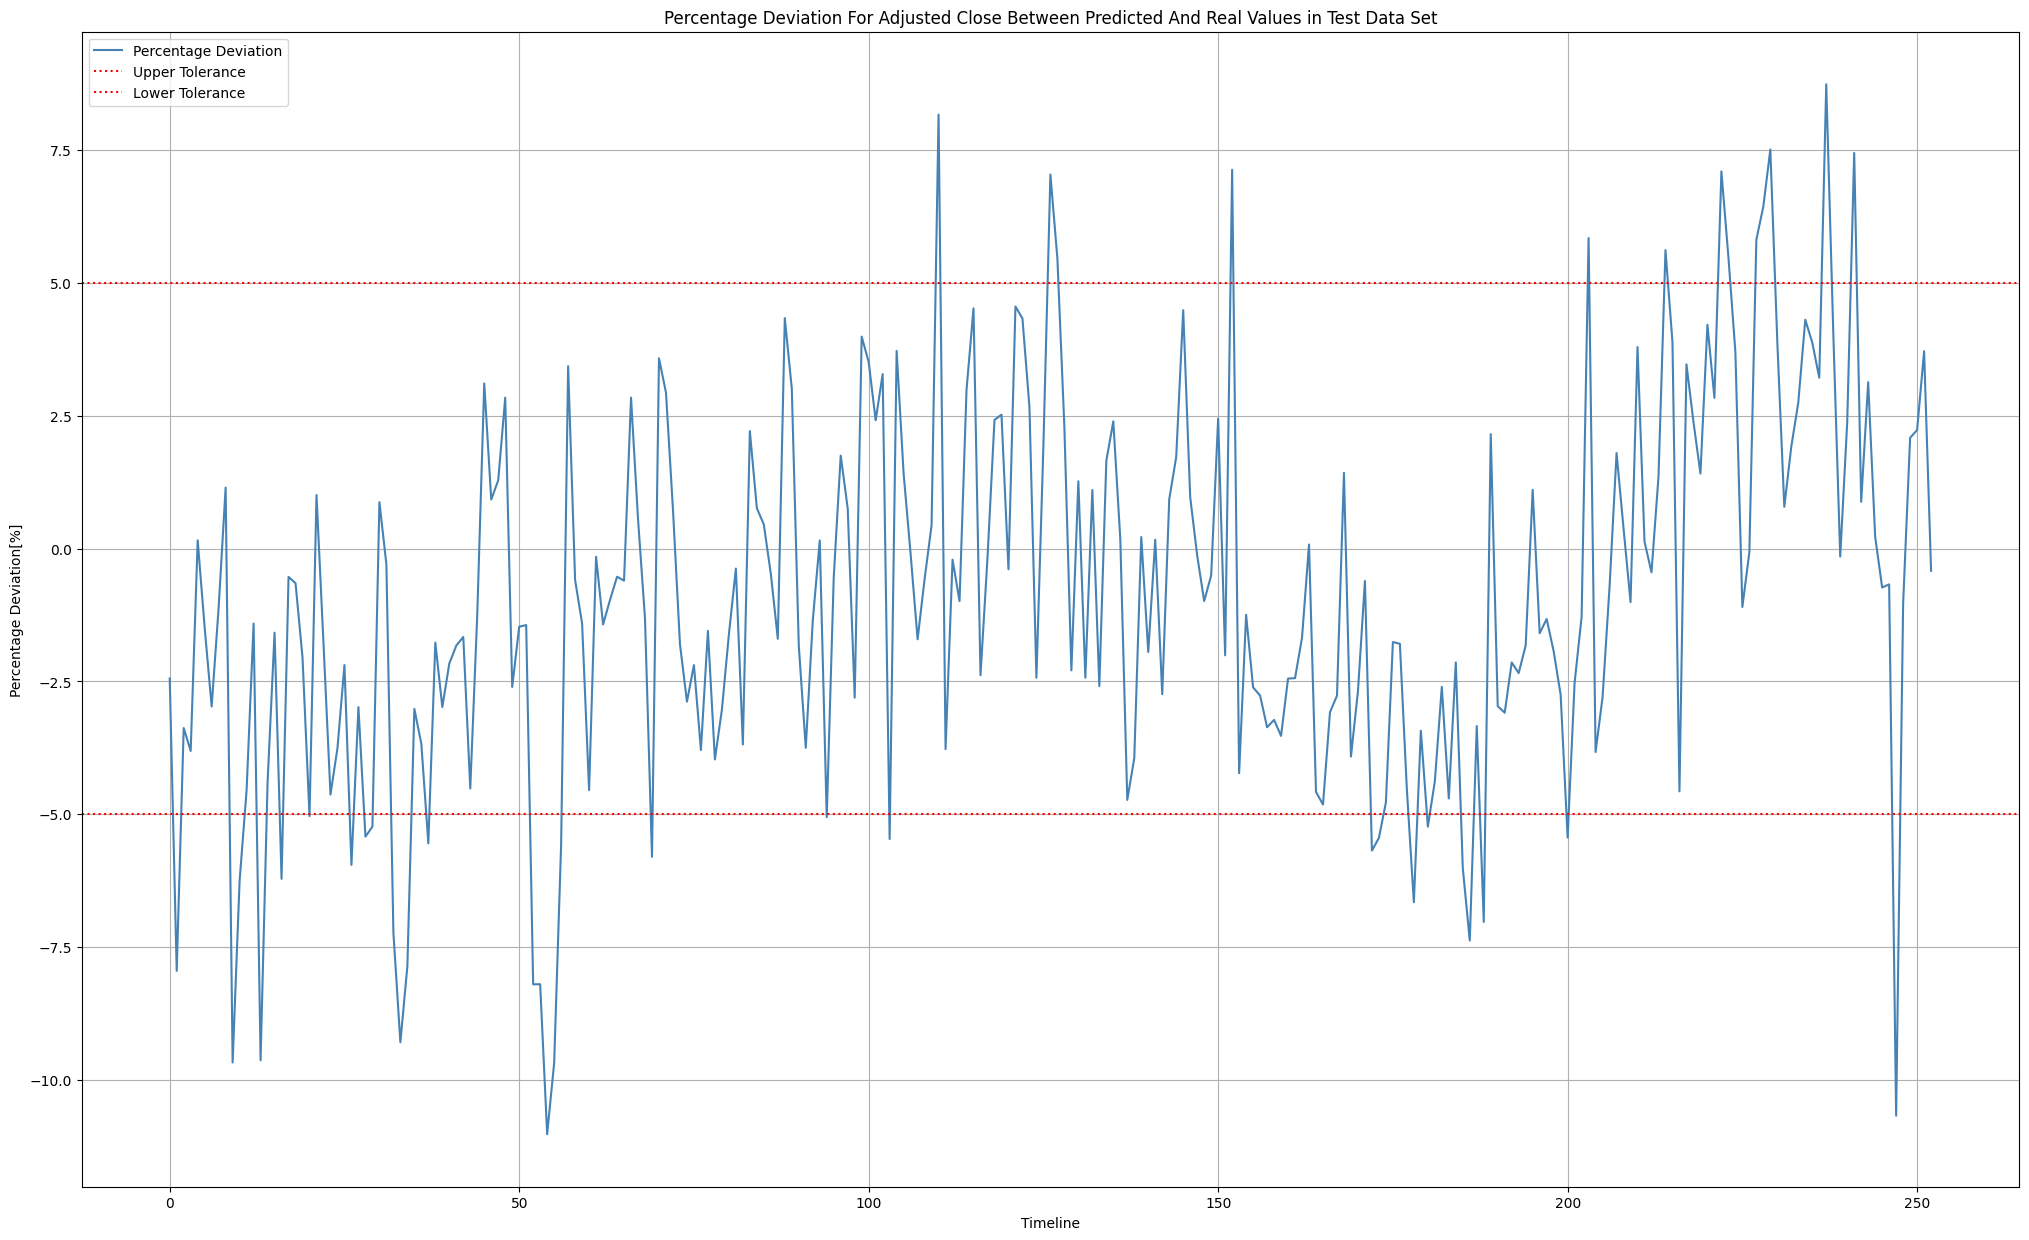

The mean for the percentage deviation in the test date is -0.9085801332194646.

----------------



In [399]:
# plot for percentage deviation between predicted and real values in test data 

# calculate the Percentage Deviation
diff_test = train_results['Train Predictions']-train_results['Actuals']
rel_diff_test = diff_test / train_results['Train Predictions']
percent_diff_test = rel_diff_test * 100

# plotting
plt.figure(figsize=(25, 15))
plt.plot(percent_diff_test.index, percent_diff_test, color='steelblue', label='Percentage Deviation')
plt.axhline(y=5, color='r', linestyle=':', label='Upper Tolerance')
plt.axhline(y=-5, color='r', linestyle=':', label='Lower Tolerance')
plt.grid()
plt.legend()
plt.ylabel('Percentage Deviation[%]')
plt.xlabel('Timeline')
plt.title('Percentage Deviation For Adjusted Close Between Predicted And Real Values in Test Data Set')
plt.show()
print('The mean for the percentage deviation in the test date is {}.'.format(sum(percent_diff_test)/len(percent_diff_test)))
print('')
print('----------------')
print('')

The LTSM model showed that it performed better that a Random Forest. Now I define a function which find the best windows size and saves the model.

In [386]:
def ltsm_model(Xs_nor, ys_nor):
    model1 = Sequential()
    model1.add(LSTM(64))
    model1.add(Dense(8, 'relu'))
    model1.add(Dense(1, 'linear'))
    
    cp1 = ModelCheckpoint('model1/', save_best_only=True)
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    best_models = {}
    for name in Xs_nor:
        
        best_models[name] = {}
        
        for window_size in range(1,20):
            
            cp1 = ModelCheckpoint('model1/', save_best_only=True, verbose=0)
            
            Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(Xs_nor, ys_nor, window_size)
            model1.add(InputLayer((window_size, 15)))
            model1.fit(np.array(Xs_train[name]), np.array(ys_train[name]), validation_data=(np.array(Xs_val[name]), np.array(ys_val[name])), epochs=50, callbacks=[cp1], verbose=0)
            
            model1 = load_model('model1/')
            
            best_models[name]['model'] = model1
            
            test_predictions = model1.predict(np.array(Xs_test[name])).flatten()
            ground_true = np.array(ys_test[name])
            
            
            diff_test = test_predictions - ground_true
            rel_diff_test = diff_test / test_predictions
            percent_diff_test = rel_diff_test * 100
            
            if window_size == 1:
                
                best_models[name]['accuracy'] = percent_diff_test
            
            else:
                
                if best_models[name]['accuracy'] > percent_diff_test:
                    
                    best_models[name]['accuracy'] = percent_diff_test
                
                else:
                    
                    continue
        
        break
                
    return best_models

In [389]:
# get the best models
best_models = ltsm_model(Xs_1, ys_1)

8/8 [==============================] - 0s 982us/step


ValueError: in user code:

    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1284, in train_function  *
        return step_function(self, iterator)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1268, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in run_step  **
        outputs = model.train_step(data)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/training.py", line 1050, in train_step
        y_pred = self(x, training=True)
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_36" is incompatible with the layer: expected shape=(None, 1, 15), found shape=(None, 2, 15)


In [ ]:
def ltsm_model(Xs_nor, ys_nor):
    model1 = Sequential()
    model1.add(LSTM(64))
    model1.add(Dense(8, 'relu'))
    model1.add(Dense(1, 'linear'))
    
    cp1 = ModelCheckpoint('model1/', save_best_only=True)
    model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])
    
    best_models = {}
        
    best_models = {}
        
    for window_size in range(1,20):
            
        cp1 = ModelCheckpoint('model1/', save_best_only=True)
            
        Xs_train, Xs_val, Xs_test, ys_train, ys_val, ys_test = train_test_lstm(Xs_nor, ys_nor, window_size)
        model1.add(InputLayer((window_size, 15)))
        model1.fit(np.array(Xs_train), np.array(ys_train), validation_data=(np.array(Xs_val), np.array(ys_val)), epochs=50, callbacks=[cp1])
            
        model1 = load_model('model1/')
            
        best_models[name]['model'] = model1
            
        test_predictions = model1.predict(np.array(Xs_test)).flatten()
        ground_true = np.array(ys_test)
            
            
        diff_test = test_predictions - ground_true
        rel_diff_test = diff_test / test_predictions
        percent_diff_test = rel_diff_test * 100
            
        try:
            if best_models[name]['model']['accuracy'] > percent_diff_test:
                    
                best_models[name]['model']['accuracy'] = percent_diff_test
                    
        except:
                
            continue
                
    return best_models

In [336]:
# get the best models
best_models = ltsm_model(Xs_1['JNJ'], ys_1['JNJ'])

KeyError: 'Open'

In [ ]:
# create the prediction for 7, 14, and 28 days

In [333]:
model1 = best_models['BMW.DE']['model']

In [334]:
test_predictions = model1.predict(np.array(Xs_test['BMW.DE'])).flatten()

# create a dataframe with predicted values and real values
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':np.array(ys_test['BMW.DE'])})

8/8 [==============================] - 0s 2ms/step


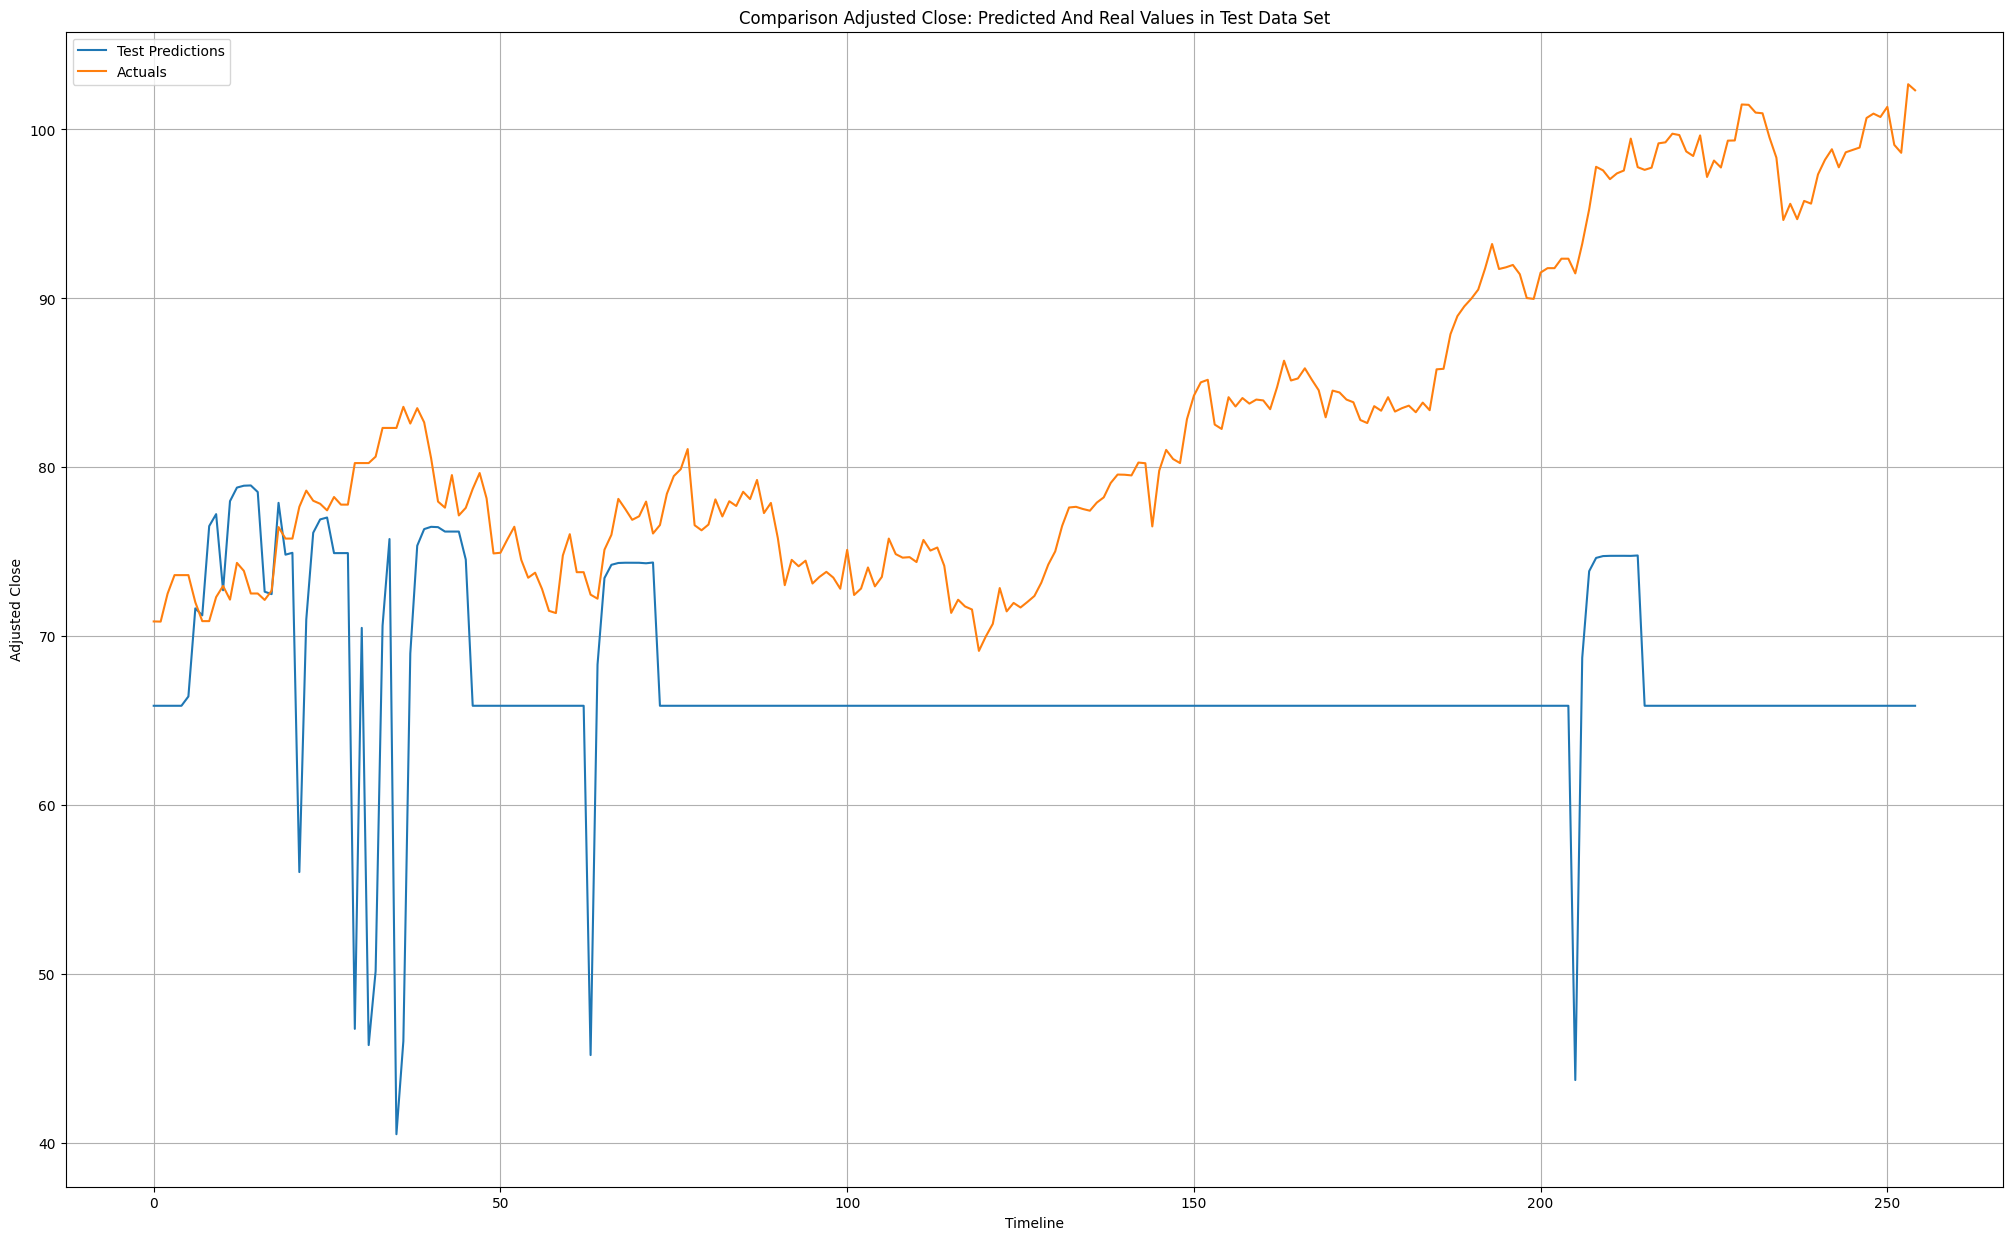

In [335]:
plt.figure(figsize=(25, 15))
plt.plot(test_results['Test Predictions'], label='Test Predictions')
plt.plot(test_results['Actuals'], label='Actuals')
plt.title('Comparison Adjusted Close: Predicted And Real Values in Test Data Set')
plt.ylabel('Adjusted Close')
plt.xlabel('Timeline')
plt.legend()
plt.grid()

In [ ]:
# to do: 
# train function: richtig kommentieren
# in der process programm immer das aktuelle datum als enddatum verwenden
# feat_eng function: richtig kommentieren
# funktion schreiben, die die besten window size findet
# herausfinden, wie ich ich auf basis von bestimmte anzahl von tagen einen wert predicte
# => immer einen tag predicten  und dann den nächsten und den näcshten Beispiel Code:
Um mit einem trainierten Zeitreihen-Machine-Learning-Modell mehrere Tage in die Zukunft vorherzusagen, können Sie entweder eine rekursive Strategie oder ein "direct multi-step forecasting" verwenden. Ich werde hier die rekursive Strategie erklären, bei der das Modell iterativ verwendet wird, um Vorhersagen für die nächsten Tage zu treffen, indem die vorhergesagten Werte als Eingabe für die zukünftigen Vorhersagen verwendet werden.

Angenommen, Sie haben ein trainiertes Modell und möchten für einen bestimmten Tag und die nächsten n_days in der Zukunft vorhersagen. Hier ist ein Beispiel in Python, wie Sie dies tun können:

python

def predict_future(model, input_data, n_days, scaler=None):
    future_predictions = []

    for _ in range(n_days):
        # Vorhersage für den nächsten Tag
        predicted_value_scaled = model.predict(input_data)
        
        # Skalierten Wert in die ursprüngliche Skala zurückverwandeln, falls notwendig
        if scaler is not None:
            predicted_value = scaler.inverse_transform(predicted_value_scaled)
        else:
            predicted_value = predicted_value_scaled

        # Füge die Vorhersage der Liste der zukünftigen Vorhersagen hinzu
        future_predictions.append(predicted_value[0, 0])

        # Aktualisiere die Eingabedaten, indem du den vorhergesagten Wert hinzufügst
        input_data = np.append(input_data[:, 1:], predicted_value_scaled)
        input_data = input_data.reshape((1, input_data.shape[0], 1))

    return future_predictions

Definition des Abfrageprozesses:
- User gibt Aktien ein, die in interessieren (einzel oder Liste)

- Daten beschaffen:
    - Immer das aktuelle Datum verwenden 
    - 10 Jahre hinter diesem Datum daten ziehen 
    - Daten über meinen aktuellen Algo beschaffen, bereinigen und speichern
    - User in einer Web App die Daten aufbereitet präsentieren 
    
    
- Daten verarbeitung:
    - Daten laden und feature engineering durchführen
    - LTSM trainieren (50 Epochen, inklusiere finden des besten window-fensters)
    - Zukunftswerte predicten: 7, 14, 28 Tage
        - Brechnung der Werte für einen Tage (Test_data) => letzten tag löschen und dann mit dem neuen Tag den nächsten Tag berechnen => Diese Werte in eine separate Liste speichern
        - In wie genau der Algo ist (in Prozent)
  
  
     - Kunden Visualisierung:
         - Testdaten zeigen in einer Farbe
         - Zukunftswerte (Kursentwicklung) in einer anderen Farbe
         - Empfehlung schreiben:
             - Ist der Wert größer nach 28 Tage: Behalten
             - kleiner: verkaufen

Neuer Plan:
- Jupyter Notebooks fertig machen
- Klassich Daten (nur Stock Namen) eingeben
    - Daten in DB speichern
    - Neues Programm: Visualisierung in einem Neuen Fenster, wenn der Kunde es wünscht
    - Neues Programm: starten für Prediction
        - Daten laden und feature engineering durchführen
        - LTSM trainieren (50 Epochen, inklusiere finden des besten window-fensters)
        - Zukunftswerte predicten: 7, 14, 28 Tage
        - Visualisierung von Status Quo zu Prediction mit Empfehlung
               - Kunden Visualisierung:
                     - Testdaten zeigen in einer Farbe
                     - Zukunftswerte (Kursentwicklung) in einer anderen Farbe
                     - Empfehlung schreiben:
                     - Ist der Wert größer nach 28 Tage: Behalten
                     - kleiner: verkaufen